In [1]:
import os 
if os.getcwd().endswith('Benchmarks'):
    os.chdir('..')

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [3]:
from Setup.MethylationAgeModels import *

importing IPython notebook from Setup/MethylationAgeModels

In [4]:
f = '/cellar/users/agross/GSE56046_methylome_normalized.txt'

In [5]:
dummy = pd.read_table(f, nrows=1, index_col=0)
cols = [c for c in dummy.columns if 'detectionPval' in c]
cols = [dummy.index.name] + cols
p_vals = pd.read_table(f, index_col=0, usecols=cols)
p_vals.columns = p_vals.columns.map(lambda s: s.split('.')[0])
p_vals = p_vals.replace(0, nan).stack()

In [6]:
cols = [c for c in dummy.columns if 'Mvalue' in c]
cols = [dummy.index.name] + cols
m_vals = pd.read_table(f, index_col=0, usecols=cols)
m_vals.columns = m_vals.columns.map(lambda s: s.split('.')[0])

In [7]:
m_2 = 2**m_vals
b_vals = m_2 / (m_2 + 1)

In [8]:
pred = run_hannum_model(b_vals)
pred2 = run_horvath_model(b_vals)

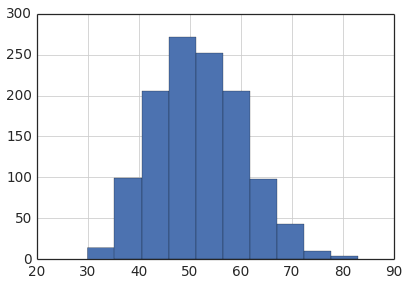

In [9]:
pred.hist()

In [10]:
tab = pd.read_csv('/cellar/users/agross/GSE56046_series_matrix.csv', header=None,
                 index_col=0)
#tab = tab.dropna()

In [11]:
desc = tab.T.describe()
tab = tab.ix[desc.ix['unique'] > 1]
tab.columns = tab.ix['!Sample_title'].map(lambda s: s.split('_')[0])
age = tab.iloc[4].map(lambda s: s.split()[-1])
age = age.astype(int)
age.name = 'age'

In [12]:
age_m = age

In [13]:
tab.ix['!Sample_title'].map(lambda s: s.split('_')[2]).value_counts()

CD14 [methylation]    1023
dtype: int64

In [14]:
pred_adj = detrend(age,pred)
pred2_adj = detrend(age, pred2)
pred_c = (pred_adj + pred2_adj) / 2
pred_c = detrend(age, pred_c)

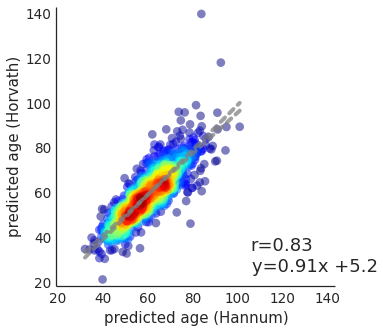

In [15]:
plot_regression(pred_adj, pred2_adj, density=True)

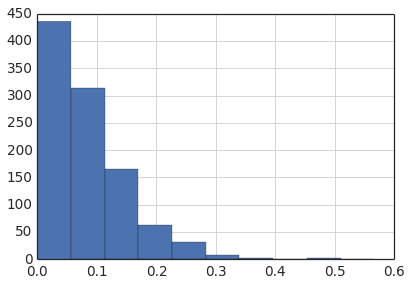

In [16]:
diff = ((pred_adj - pred2_adj) / ((pred_adj + pred2_adj) * .5)).abs()
diff.hist()

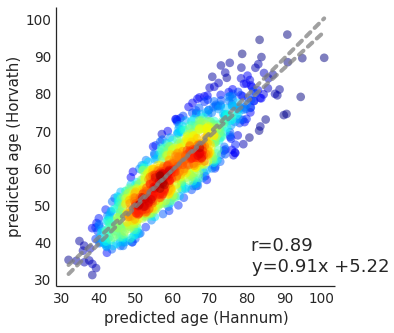

In [17]:
plot_regression(pred_adj, pred2_adj.ix[ti(diff < .2)], density=True)

In [18]:
k = ti(diff < .2)
pred_adj = detrend(age.ix[k],pred)
pred2_adj = detrend(age.ix[k], pred2)
pred_c = (pred_adj + pred2_adj) / 2
pred_c = detrend(age, pred_c)

In [19]:
pred_c.name = 'methylation age'

In [20]:
pred_c_mono = pred_c

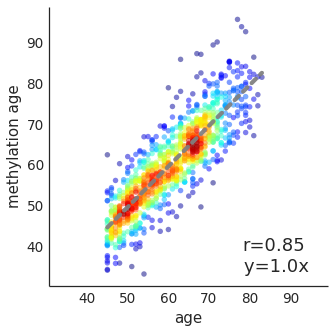

In [21]:
plot_regression(age, pred_c, s=30, density=True)

In [22]:
age_corr = m_vals.T.ix[age.index].corrwith(age.astype(float))

In [23]:
age_corr.to_csv('/cellar/users/agross/Data/Methylation_Controls/monocyte_age_corr.csv')

In [24]:
f = '/cellar/users/agross/Data/Methylation_Controls/Reynolds/GSE56581_methylome_normalized.txt'

In [25]:
dummy = pd.read_table(f, nrows=1, index_col=0)
cols = [c for c in dummy.columns if 'Mvalue' in c]
cols = [dummy.index.name] + cols
m_vals = pd.read_table(f, index_col=0, usecols=cols)
m_vals.columns = m_vals.columns.map(lambda s: s.split('.')[0])

In [26]:
m_2 = 2**m_vals
b_vals = m_2 / (m_2 + 1)

In [27]:
tab = pd.read_table('/cellar/users/agross/Data/Methylation_Controls/Reynolds/GSE56581_series_matrix.txt', 
                    header=None,
                    index_col=0, skiprows=35)
desc = tab.T.describe()
tab = tab.ix[desc.ix['unique'] > 1]
tab.columns = tab.ix['!Sample_title'].map(lambda s: s.split('_')[0])
age = tab.iloc[4].map(lambda s: s.split()[-1])
age = age.astype(int)
age.name = 'age'
#tab = tab.dropna()
age_t = age

In [28]:
age = age_m.combine_first(age_t)

In [29]:
pred_t = run_hannum_model(b_vals)
pred2_t = run_horvath_model(b_vals)

In [30]:
pred_adj = detrend(age,pred_t)
pred2_adj = detrend(age, pred2_t)
pred_c_t = (pred_adj + pred2_adj) / 2
pred_c_t = detrend(age, pred_c_t)

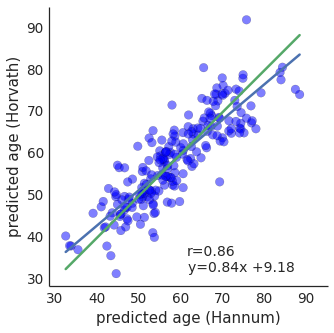

In [31]:
plot_regression(pred_adj, pred2_adj)

In [32]:
k = ti(diff < .2)
pred_adj = detrend(age,pred_t.ix[k])
pred2_adj = detrend(age, pred2_t.ix[k])
pred_c_t = (pred_adj + pred2_adj) / 2
pred_c_t = detrend(age, pred_c_t)

In [33]:
pred_c.name = 'methylation age'

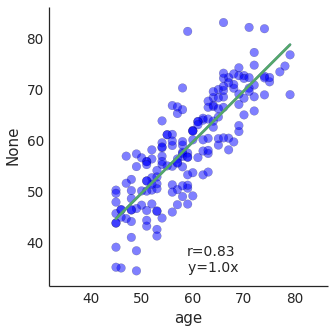

In [34]:
plot_regression(age, pred_c_t)

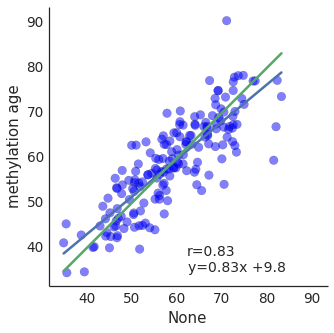

In [35]:
plot_regression(pred_c_t, pred_c)

In [36]:
pt = pred_c_t.index.intersection(age.index).intersection(pred_c.index)
fisher_exact_test(pred_c_t[pt] > age[pt], (pred_c[pt] > age[pt]))

odds_ratio    3.55e+00
p             7.90e-05
dtype: float64

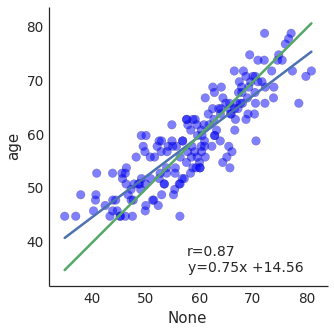

In [37]:
plot_regression((pred_c_t + pred_c) / 2., age)

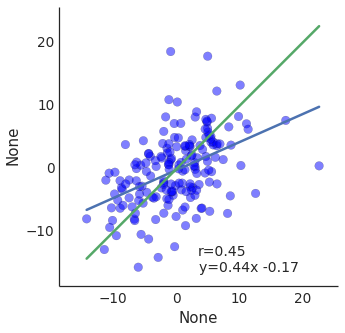

In [38]:
plot_regression(pred_c_t - age, (pred_c - age).dropna())

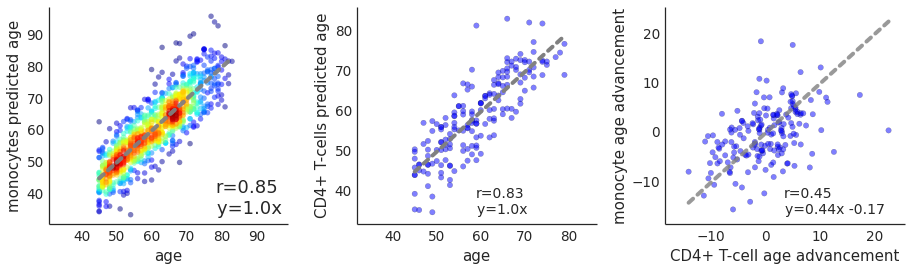

In [39]:
fig, axs = subplots(1,3, figsize=(13,4))
pred_c_t.name = 'CD4+ T-cells predicted age'
pred_c_mono.name = 'monocytes predicted age'
plot_regression(age, pred_c_mono, s=30, density=True, ax=axs[0])
plot_regression(age, pred_c_t, s=30, density=False, ax=axs[1],
                line_args=[{'lw':0}, {'color':'grey', 'lw': 4, 'ls':'--',
                                     'dash_capstyle': 'round'}])
plot_regression((pred_c_t - age).dropna(), pred_c_mono - age, ax=axs[2],
                s=30, density=False, 
                line_args=[{'lw':0}, {'color':'grey', 'lw': 4, 'ls':'--',
                                      'alpha':.8,
                                     'dash_capstyle': 'round'}])
axs[2].set_xlabel('CD4+ T-cell age advancement')
axs[2].set_ylabel('monocyte age advancement')
fig.tight_layout()

In [46]:
pearson_pandas((pred_c_t - age).dropna(), pred_c_mono - age)

rho    4.52e-01
p      3.02e-10
dtype: float64

In [40]:
a,b = match_series(pred_c_t - age, (pred_c - age).dropna())

In [41]:
pts = m_vals.columns.intersection(age.index)
age_corr_t = m_vals.T.ix[pts].corrwith(age.ix[pts].astype(float))

In [42]:
pearson_pandas(age_corr, age_corr_t)

rho    0.32
p      0.00
dtype: float64

In [43]:
age_corr_t.to_csv('/cellar/users/agross/Data/Methylation_Controls/CD4T_age_corr.csv')